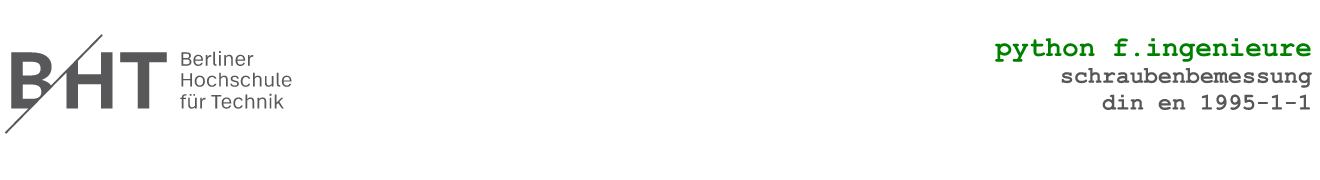

# Anwendungsbeispiel 2: Schraubenbemessung 

## Vollständiger Code
### Schematischer Ablauf

Wie bereits in der Kurzbeschreibung erläutert, lässt sich das Programm unterteilen in einzelne Abschnitte. Im Folgenden ist der gesamte und vollständige Code dargestellt, der aus den einzelnen Elementen zusammengesetzt ist, die in den vorherigen Kapiteln besprochen wurden.

Aufgrund der Länge und Abstraktheit des Codes wird der Ablauf des Algorithmus anhand eines Schemas skizziert.

In den Punkten **1** bis **2** wird mit Streamlit die Seitenleiste konstruiert, die mit verschiedenen Eingabeelementen die Eingangsparameter des Nutzers speichert. Um ein möglichst ruckelfreies Nutzen der Bemessungstabellen zu gewährleisten, wird bereits nach der Eingabe der Parameter die Tragfähigkeiten für alle Längen berechnet und in Dictionaries gespeichert (**3**). Auf der Hauptseite kann nun zwischen der Anzeige der Bemessungstabellen und des Einzelnachweises gewählt werden (**4**). Die Bemessungstabellen und -diagramme sind für je Durchmesser in Registerkarten aufgeteilt. Jeder Reiter beinhaltet eine Tabelle und Diagramme für die Axial- und Schertragfähigkeiten der Schrauben (**5**). Hier besteht die Möglichkeit über die Wahl von Filtern Schrauben auszublenden, die hinsichtlich der Einwirkung und Geometrie unzulässig sind. Für die Anzeige eines Einzelnachweises (**6**) wird ein Durchmesser und eine Länge der Schraube gewählt.

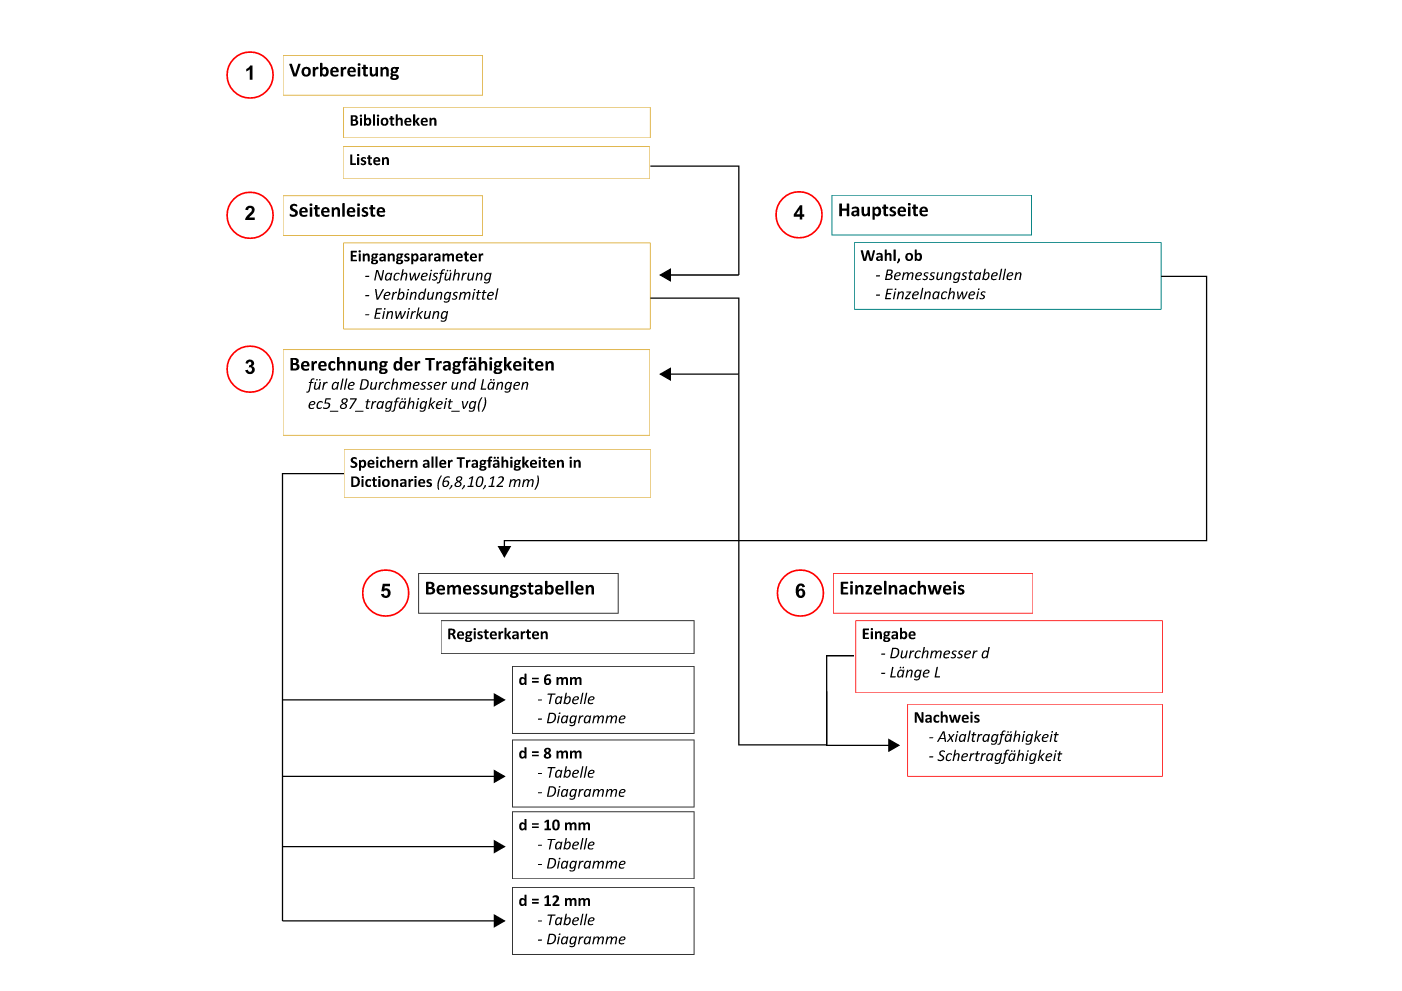
<center> Abbildung 2: Schematischer Ablauf des Codes </center><br>

### Code

In [ ]:
# Schraubenbemessungsprogramm: Webapp mit Streamlit - Axial- und Schertragfähigkeit von Würth Vollgewindeschrauben
# Bibliotheken
from math import pi, sqrt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import streamlit as st
from schraubenbemessung_ec5_87_functions import get_length, ec5_87_tragfähigkeit_vg

# HTML Einstellungen
st.set_page_config(layout="wide")
st.markdown("""<style>
[data-testid="stSidebar"][aria-expanded="false"] > div:first-child {width: 500px;}
[data-testid="stSidebar"][aria-expanded="false"] > div:first-child {width: 500px;margin-left: -500px;}
</style>""",unsafe_allow_html=True)

# Eingangsparameter
# Listen
L_kled = ['ständig', 'lang', 'mittel', 'kurz', 'sehr kurz']
L_kmod = [[0.6, 0.7, 0.8, 0.9, 1.1], [
    0.6, 0.7, 0.8, 0.9, 1.1], [0.5, 0.55, 0.65, 0.7, 0.9]]
L_rho_k = [380, 350, 410, 380, 430, 410, 450, 430]
L_holzart = ['GL24h', 'GL24c', 'GL28h',
             'GL28c', 'GL32h', 'GL32c', 'GL36h', 'GL36c']
L_di_axial = [[], [], [], []]
L_di_scher = [[], [], [], []]
L_no = [[], [], [], []]
L_d = [6, 8, 10, 12]


#__________Seitenleiste__________

with st.sidebar:

    # Eingabewerte
    # Überschrift
    st.title('Eingangsparameter')
    st.subheader('Beiwerte')

    # Nachweisführung
    nachweisführung = st.radio(
        'Nachweisführung', ('Charakteristische Werte', 'Bemessungswerte'), horizontal=True)
    if nachweisführung == 'Bemessungswerte':
        nkl = st.selectbox('Nutzungsklasse', [1, 2, 3])
        kled = st.selectbox('Lasteinwirkung', L_kled)
        index = L_kled.index(kled)
        k_mod = L_kmod[nkl][index]
        gamma = 1.3
        chi = k_mod/gamma
    else:
        chi = 1

    # Verbindungsmittel
    st.subheader('Verbindungsmittel')
    hersteller = 'Würth'
    holzart = st.selectbox('Holzgüte', L_holzart)
    t_1 = int(st.text_input('Seitenholz 1 [mm]', 50))
    t_2 = int(st.text_input('Seitenholz 2 [mm]', 100))
    t_Blech = int(st.text_input('Blechdicke [mm]', 0))
    alpha = int(st.text_input('Winkel', 0))

    # Einwirkung
    st.subheader('Einwirkung')
    F_t = int(st.text_input('Zugkraft [kN]', 4))
    F_v = int(st.text_input('Querkraft [kN]', 2))
    blank = st.write('')
    button_einlesen = st.button('Einlesen')
    blank = st.write('')

    # Bearbeitung der Eingabwerte
    if t_Blech == 0:
        L_tot = t_1+t_2  # Länge
    else:
        L_tot = t_1+t_Blech  # Länge
    L_L, L_Li = get_length(hersteller, 6)  # Liste der Längen
    index = L_holzart.index(holzart)  # Rohdichte des Holzes (Index)
    rho_k = L_rho_k[index]  # Rohdichte des Holzes

    #__________Berechnung der Tragfähigkeit__________

    if 'Einlesen':

        # Berechnung aller Tragfähigkeiten mit Funktion ec5_87_tragfähigkeit_vg()
        for n, d in enumerate(L_d):
            for m, L in enumerate(L_L[n]):
                F_axRk, F_vRk, nw = ec5_87_tragfähigkeit_vg(
                    'Würth', d, L, t_1, t_2, t_Blech, rho_k, alpha)
                L_di_axial[n].append(round(F_axRk*chi, 2))
                L_di_scher[n].append(round(F_vRk*chi, 2))
                L_no[n].append(m+1.5)

        # Dictionary für jeden Durchmesser
        # Durchmesser 6 mm
        dict_d6 = {'L': L_L[0], 'F_axRk': L_di_axial[0],
                   'F_vRk': L_di_scher[0]}
        df_d6 = pd.DataFrame(dict_d6)
        # Durchmesser 8 mm
        dict_d8 = {'L': L_L[1], 'F_axRk': L_di_axial[1],
                   'F_vRk': L_di_scher[1]}
        df_d8 = pd.DataFrame(dict_d8)
        # Durchmesser 10 mm
        dict_d10 = {'L': L_L[2], 'F_axRk': L_di_axial[2],
                    'F_vRk': L_di_scher[2]}
        df_d10 = pd.DataFrame(dict_d10)
        # Durchmesser 12 mm
        dict_d12 = {'L': L_L[3], 'F_axRk': L_di_axial[3],
                    'F_vRk': L_di_scher[3]}
        df_d12 = pd.DataFrame(dict_d12)
        # Dictionaries in Listen verpacken
        L_dict = [df_d6, df_d8, df_d10, df_d12]


#__________Hauptseite__________

# Text
st.image('image_header_vg.png')
st.title('Bemessung von Vollgewindeschrauben')
st.write('DIN EN 1995-1-1 Abs. 8 & ETA-11/0190')
st.write('Dieses Programm ermittelt die Tragfähigkeiten von Vollgewindeschrauben hinsichtlich einer Axial- und Scherbeanspruchung. \
        Die herstellerspezifischen Kennwerte beziehen sich auf eine **Würth ASSY plus VG** als Senkkopfausführung.')
st.image('image_vg.png')
st.subheader('Nachweisführung')
betrachtung = st.selectbox('', ('Bemessungstabellen', 'Einzelnachweis'))

# Widerstandsbeiwerte
if nachweisführung == 'Bemessungswerte':
    st.write('Widerstandsbeiwerte')
    col1, col2 = st.columns(2, gap="small")
    with col1:
        st.latex('k_{mod} = ' + str(k_mod))
    with col2:
        st.latex('\gamma_{m} = ' + str(gamma))

#__________Bemessungstabelle__________

if betrachtung == 'Bemessungstabellen':

    # Text
    st.title('Bemessungstabellen')
    st.subheader('Filter')

    # Filter
    options_filter = st.multiselect('', ['Längen', 'Tragfähigkeit'])

    # Einganswerte
    # Listen und Dictionaries
    fig_6 = fig_8 = fig_10 = fig_12 = []
    table_6 = table_8 = table_10 = table_12 = []
    L_fig = [fig_6, fig_8, fig_10, fig_12]
    L_table = [table_6, table_8, table_10, table_12]
    L_keys = ['f6', 'f8', 'f10', 'f12']

    # Tabs
    st.write('Durchmesser')
    col_d6, col_d8, col_d10, col_d12 = st.tabs(
        ["6 mm", "8 mm", "10 mm", "12 mm"])

    # Schleife für Reiter (Tabs)
    for n, tab_i in enumerate([col_d6, col_d8, col_d10, col_d12]):

        # Tab
        with tab_i:

            # Listen
            # Allgemein
            red = '#ff4b4b'
            light_grey = '#f0f2f6'
            grey = '#bfced8'
            dark_grey = 'lightslategrey'
            L_Li = L_L[n]
            L_di_axiali = L_di_axial[n]
            L_di_scheri = L_di_scher[n]
            # Diagramme
            L_title = ["Axialtragfähigkeit", "Schertragfähigkeit"]
            L_text = ["Axialkraft", "Scherkraft"]
            L_hover = ["F_axRd", "F_vRd"]
            L_F = [F_t, F_v]
            L_colors = [dark_grey, red]
            L_colors_bar = [[], []]
            L_font = {'color': 'white'}
            L_font_prozent = [{'color': 'white'}, {'color': 'white'}]
            L_color_font = [[], []]
            L_color_fill = [[], []]
            # Tabelle
            L_t_fill1 = []
            L_t_fill2 = []
            L_t_fill3 = []
            dict_header = {'values': [('L', '[mm]'),  ('F_axRk', '[kN]'), ('F_vRk', '[kN]')],
                           'align': 'center', 'font': {'size': 15, 'color': 'black'}, 'fill_color': grey, 'line_color': 'white'}
            dict_cells = {'values': [L_Li,  L_di_axiali, L_di_scheri], 'height': 30, 'font': {'size': 15, 'color': 'black'},
                          'fill_color': [L_t_fill1, L_t_fill2, L_t_fill3]}

            # Fehlermeldung
            st.subheader('Würth ASSY Plus VG')
            if nw[0] != 'success':
                st.subheader(nw[0])
                st.write(nw[1])
            else:

                #__________Tabelle__________

                tabelle = L_table[n]

                # Tabellen
                # Dynamische Anpassung der Farben entsprechend der Filter
                # Filter (Tragfähigkeit, Längen, Tragfähigkeit & Längen)
                for i in range(len(L_Li)):

                    if (options_filter == ["Tragfähigkeit", "Längen"] or options_filter == ["Längen", "Tragfähigkeit"]):

                        dict_cells['fill_color'][0].append(light_grey)

                        if L_Li[i] > L_tot or L_di_axiali[i] == 0 or L_di_scheri[i] == 0:
                            dict_cells['fill_color'][1].append(light_grey)

                        elif L_di_axiali[i] > F_t and L_Li[i] < L_tot:
                            dict_cells['fill_color'][1].append(dark_grey)
                        else:
                            dict_cells['fill_color'][1].append(light_grey)

                        if L_Li[i] > L_tot or L_di_axiali[i] == 0 or L_di_scheri[i] == 0:
                            dict_cells['fill_color'][2].append(light_grey)

                        elif L_Li[i] < L_tot and L_di_scheri[i] > F_v:
                            dict_cells['fill_color'][2].append(red)
                        else:
                            dict_cells['fill_color'][2].append(light_grey)

                    elif (options_filter == ["Tragfähigkeit"] and options_filter != ["Längen"]):
                        dict_cells['fill_color'][0].append(light_grey)

                        if L_di_axiali[i] < F_t:
                            dict_cells['fill_color'][1].append(light_grey)
                        else:
                            dict_cells['fill_color'][1].append(dark_grey)

                        if L_di_scheri[i] < F_v:
                            dict_cells['fill_color'][2].append(light_grey)
                        else:
                            dict_cells['fill_color'][2].append(red)

                    elif (options_filter == ["Längen"] and options_filter != ["Tragfähigkeit"]):
                        dict_cells['fill_color'][0].append(light_grey)

                        if L_Li[i] < L_tot:
                            dict_cells['fill_color'][1].append(dark_grey)
                            dict_cells['fill_color'][2].append(red)
                        else:
                            dict_cells['fill_color'][1].append(light_grey)
                            dict_cells['fill_color'][2].append(light_grey)

                    else:
                        dict_cells['fill_color'][0].append(light_grey)
                        dict_cells['fill_color'][1].append(light_grey)
                        dict_cells['fill_color'][2].append(light_grey)

                # Erstellen der Tabelle
                tabelle = go.Figure(
                    data=[go.Table(header=dict_header, cells=dict_cells, columnwidth=[40])])
                tabelle.update_layout(
                    width=1100, height=600, title_text='Tabelle')
                st.write(tabelle)

                #__________Diagramme__________

                # Erzeugung von 2 Diagrammen für die Axial- und Schertragfähigkeit
                for m, Frd_i in enumerate([L_di_axiali, L_di_scheri]):

                    # Plotly Balkendiagramm
                    y_max = max(Frd_i)
                    fig = L_fig[n]
                    annotations = go.Annotations()

                    # Plotly Balkendiagramm
                    fig = px.bar(L_dict[n], x=L_no[n], y=Frd_i, height=600, width=1100,
                                 title=L_title[m], text_auto=True, hover_name='L')

                    # Hinzufügen der x-Achse (Längen)
                    for j in range(len(L_Li)):
                        fig.add_annotation(
                            text=L_Li[j], x=L_no[n][j], y=-y_max/20, showarrow=False)

                    # Anwendung der Filter
                    # Filter Tragfähigkeit
                    for p, Frd in enumerate(Frd_i):

                        if options_filter == ["Tragfähigkeit"]:

                            # Ausnutzung als Beschriftung
                            for k in range(len(L_dict[n])):

                                # if-Abfrage zur Vermeidung der Division durch 0
                                if Frd_i[k] == 0:
                                    print("")
                                else:
                                    annotations.append(go.Annotation(text=str(f"{round(L_F[m]/Frd_i[k],2):.0%}"),
                                                                     x=k+1.5,
                                                                     y=Frd_i[k] +
                                                                     y_max/20,
                                                                     xref='x', yref='y', showarrow=False, font={'color': 'lightslategrey'}))

                            # Dynamische Anpassung der Farben entsprechend der Filter
                            if Frd > L_F[m]:
                                L_colors_bar[m].append(L_colors[m])
                            else:
                                L_colors_bar[m].append('lightgray')

                        # Filter Längen
                        elif options_filter == ["Längen"]:

                            L_tot = t_1+t_2

                            # Dynamische Anpassung der Farben entsprechend der Filter
                            if L_Li[p] < L_tot:
                                L_colors_bar[m].append(L_colors[m])
                            else:
                                L_colors_bar[m].append('lightgray')

                        # Filter Längen & Tragfähigkeit
                        elif options_filter == ["Tragfähigkeit", "Längen"] or options_filter == ["Längen", "Tragfähigkeit"]:

                            # Ausnutzung als Beschriftung
                            for k in range(len(L_dict[n])):

                                # if-Abfrage zur Vermeidung der Division durch 0
                                if Frd_i[k] == 0:
                                    print("")
                                else:
                                    annotations.append(go.Annotation(text=str(f"{round(L_F[m]/Frd_i[k],2):.0%}"),
                                                                     x=k+1.5,
                                                                     y=Frd_i[k] +
                                                                     y_max/20,
                                                                     xref='x', yref='y', showarrow=False, font={'color': 'lightslategrey'}))

                            # Dynamische Anpassung der Farben entsprechend der Filter
                            if Frd > L_F[m] and L_Li[p] < L_tot:
                                L_colors_bar[m].append(L_colors[m])
                            else:
                                L_colors_bar[m].append('lightgray')

                        elif options_filter == []:
                            L_colors_bar[m].append(L_colors[m])

                    # Erzeugen der Diagramme
                    fig.update_traces(
                        marker_color=L_colors_bar[m], textfont=L_font_prozent[m])
                    fig.update_layout(annotations=annotations)
                    fig.update_yaxes(title_text="Tragfähigkeit [kN]")
                    fig.update_xaxes(
                        showticklabels=False, tickangle=90, title_text="Längen [mm]", type='linear')
                    fig.update_layout(barmode='group', autosize=False)
                    fig.update_traces(hovertemplate="<br>".join(
                        ["%{L_hover[m]} = %{y} kN"]))
                    st.plotly_chart(fig)

#__________Einzelnachweise__________


if betrachtung == 'Einzelnachweis':

    st.title('Einzelnachweis')
    st.subheader('Eingabewerte')
    d = int(st.selectbox('Durchmesser [mm]', (6, 8, 10, 12)))
    L = int(st.selectbox('Längen [mm]', get_length(hersteller, d)[1]))

    # Schalter
    button_axial = st.button('Berechnen')

    if button_axial:

        st.header('Ergebnisse')
        alph = alpha*pi/180
        t_2 = L-t_1
        if t_Blech != 0:
            l_ef = L-t_Blech
        elif t_Blech == 0:
            l_ef = min(L-t_1, t_1)

        # Einganswerte
        if hersteller == 'Würth':
            # WÜrth
            L_d = [6, 8, 10, 12]
            L_f_axk = [11.5, 11, 10, 10]
            L_f_tensk = [11, 20, 32, 45]
            L_d_h = [14, 22, 25.2, 29.4]
            L_f_head = [13, 13, 10, 10]

        # Index für Kennwerte
        index = L_d.index(d)
        d = L_d[index]
        d_h = L_d_h[index]
        f_head = L_f_head[index]
        f_axk = L_f_axk[index]
        f_tensk = L_f_tensk[index]
        M_yrk = round(0.15*600*d**(2.6), 2)
        f_hk = round((0.082*rho_k*d**(-0.3)), 2)
        k_axk = 0.3+(0.7*alpha)/45 if alpha <= 45 else 1

        # Auflistung der Kennwerte und Eingangswerte
        st.subheader('Kennwerte')
        st.write('ETA-11/0190')
        col1, col2 = st.columns(2)
        with col1:
            st.latex('d_{h} = ' + str(d_h) + ' mm')
            st.latex('l_{eff} = ' + str(l_ef) + ' mm')
            st.latex(r'''\rho_{k} = ''' + str(rho_k) + ' kg/m^3')
            st.latex('k_{axk} = ' + str(k_axk))
        with col2:
            st.latex('f_{headk} = ' + str(f_head) + ' N/mm^2')
            st.latex('f_{axk} = ' + str(f_axk) + ' N/mm^2')
            st.latex('f_{tensk} = ' + str(f_tensk) + ' N/mm^2')
            st.latex('M_{yRk} = ' + str(M_yrk) + ' Nmm')

        #__________Ausziehwiderstand__________

        st.subheader('Ausziehwiderstand')
        # Ausziehwiderstand
        # Berechnung
        F_axrk1 = (k_axk*f_axk*d*l_ef) * (rho_k/350)**0.8  # N
        F_axRk1 = round(F_axrk1/1000, 2)
        # LATEX
        st.latex(
            r''' F_{axRk}  =  k_{axk} * f_{axk} * l_{ef} * \left(\frac{\rho_{k}}{350} \right)^{0.8} = ''' + str(F_axRk1) + ' kN')

        # Kopfdurchzieh
        # Berechnung
        F_headrk = f_head*(d_h)**2 * (rho_k/350)**0.8
        # F_headrk =  (k_axk*f_axk*d*4*d) * (rho_k/350)**0.8 #N
        F_headRk = round(F_headrk/1000, 2)

        # LATEX
        st.subheader('Kopfdurchziehwiderstand')
        st.latex(
            r'''F_{headRk}  = f_{head} * d_{h}^2 * \left(\frac{\rho_k}{350} \right)^{0.8} = ''' + str(F_headRk) + ' kN')

        # Zugfestigkeit
        # Berechnung
        F_tRk = f_tensk
        # LATEX
        st.subheader('Zugtragfähigkeit')
        st.latex('F_{tRk} = f_{tensk} = ' + str(F_tRk) + ' kN')

        st.subheader('Axialtragfähigkeit')
        st.write('DIN EN 1995-1-1 Abs. 8.7.2')
        if t_Blech != 0 or t_2 > 4*d:
            # if t_Blech != 0:
            F_axRk = min(F_axRk1, F_tRk)
            F_axrk = min(F_axrk1, F_tRk*1000)
            st.write('Kopfdurchziehtragfähigkeit nicht zu berücksichtigen.')
            st.latex(r'''  F_{axRk} = min( ''' + rf'''{F_axRk1}, ''' +
                     rf'''{F_tRk}) = ''' + str(F_axRk) + ' kN')

        elif t_Blech == 0 or t_2 < 4*d:
            # elif t_Blech == 0:
            F_axRk = min(F_axRk1, F_headRk, F_tRk)
            F_axrk = min(F_axrk1, F_headrk, F_tRk*1000)
            st.latex(r'''  F_{axRk} = min( ''' + rf'''{F_axRk1}, ''' +
                     rf'''{F_headRk}, ''' + rf'''{F_tRk})  = ''' + str(F_axRk) + ' kN')

        #__________Schertragfähigkeit__________
        
        # Holz-Holz
        st.subheader('Schertragfähigkeit')
        if t_Blech == 0:

            F_vk1 = round(f_hk*t_1*d, 2)
            F_vk2 = round(f_hk*t_2*d, 2)
            F_vk3 = round((f_hk*t_1*d)/2 * (sqrt(1+2*(1+t_2/t_1 +
                          (t_2/t_1)**2)+(t_2/t_1)**2)-(1+t_2/t_1))+F_axrk/4, 2)
            F_vk4 = 1.05*(f_hk*t_1*d)/(3) * \
                (sqrt(4+(12*M_yrk)/(f_hk*t_1**2*d))-1)+F_axrk/4
            F_vk5 = 1.05*(f_hk*t_2*d)/(3) * \
                (sqrt(4+(12*M_yrk)/(f_hk*t_2**2*d))-1)+F_axrk/4
            F_vk6 = 1.15*sqrt(2*M_yrk*f_hk*d)+F_axrk/4
            F_vrk = min(F_vk1, F_vk2, F_vk3, F_vk4, F_vk5, F_vk6)

            F_vRk1 = round(F_vk1/1000, 2)
            F_vRk2 = round(F_vk2/1000, 2)
            F_vRk3 = round(F_vk3/1000, 2)
            F_vRk4 = round(F_vk4/1000, 2)
            F_vRk5 = round(F_vk5/1000, 2)
            F_vRk6 = round(F_vk6/1000, 2)
            F_vRk = round(F_vrk/1000, 2)

            st.write('einschnittige Holz-Holz Verbindung.')
            st.write('DIN EN 1995-1-1 Abs. 8.2.2 (8.6)')
            st.latex(r''' F_{vk1} = f_{hk}*t_{1}*d =  ''' +
                     str(F_vRk1) + ' kN')
            st.latex(r''' F_{vk2} = f_{hk}*t_{2}*d =  ''' +
                     str(F_vRk2) + ' kN')
            st.latex(r''' F_{vk3} = \frac{f_{hk}*t_{1}*d}{1+\beta}*\left(\sqrt{1+2\beta^2*(1+\frac{t_2}{t_1}+\left(\frac{t_2}{t_1}\right)^2)+\beta^3\left(\frac{t_2}{t_1}\right)^2} - \beta\left(1+\frac{t_2}{t_1}\right)\right) + \frac{F_{axRk}}{4} = ''' + str(F_vRk3) + ' kN')
            st.latex(r''' F_{vk4} = 1.05 * \frac{f_{hk}*t_{1}*d}{2+\beta}*\left(\sqrt{2\beta*(1+\beta)+\frac{4*\beta*(2+\beta)*M_{yRk}}{f_{hk}*d*t_{1}^2}}-\beta\right) + \frac{F_{axRk}}{4} = ''' + str(F_vRk4) + ' kN')
            st.latex(r''' F_{vk5} = 1.05 * \frac{f_{hk}*t_{2}*d}{1+2\beta}*\left(\sqrt{2\beta^2*(1+\beta)+\frac{4*\beta*(1+2\beta)*M_{yRk}}{f_{hk}*d*t_{2}^2}}-\beta\right) + \frac{F_{axRk}}{4} = ''' + str(F_vRk5) + ' kN')
            st.latex(
                r''' F_{vk6} = 1.15 * \sqrt{\frac{2\beta}{1+\beta}}*\sqrt{2*M_{yRk}*f_{hk}*d} + \frac{F_{axRk}}{4} = ''' + str(F_vRk6) + ' kN')

            st.latex(r'''  F_{vRk} = min( ''' + rf'''{F_vRk1}, ''' + rf'''{F_vRk2}, ''' + rf'''{F_vRk3}, ''' +
                     rf'''{F_vRk4}, ''' + rf'''{F_vRk5}, ''' + rf'''{F_vRk6})  = ''' + str(F_vRk) + ' kN')

        # Holz-Stahl (einschnittig)
        # dickes Stahlblech
        elif t_Blech >= d:

            F_vk1 = f_hk*t_1*d
            F_vk2 = f_hk*t_1*d*(sqrt(2+(4*M_yrk)/(f_hk*d*t_1**2))-1)+F_axrk/4
            F_vk3 = 2.3*sqrt(M_yrk*f_hk*d)+F_axrk/4
            F_vrk = min(F_vk1, F_vk2, F_vk3)

            F_vRk1 = round(F_vk1/1000, 2)
            F_vRk2 = round(F_vk2/1000, 2)
            F_vRk3 = round(F_vk3/1000, 2)
            F_vRk = round(F_vrk/1000, 2)

            st.write(
                'Einschnittige Stahl-Holz Verbindung mit einem dicken Stahlblech.')
            st.write('DIN EN 1995-1-1 Abs. 8.2.3 (8.10)')
            st.latex(r''' F_{vk1} = f_{hk}*t_{1}*d =  ''' +
                     str(F_vRk1) + ' kN')
            st.latex(
                r''' F_{vk2} = f_{hk}*t_{2}*d * \left( \sqrt{2+ r( \frac{4*M_{yRk}}{f_{hk}*d*t_{1}^2}} ) \right) + \frac{F_{axRk}}{4} = ''' + str(F_vRk2) + ' kN')
            st.latex(
                r''' F_{vk3} = 2.3 * \sqrt{2*M_{yRk}*f_{hk}*d} + \frac{F_{axRk}}{4} = ''' + str(F_vRk3) + ' kN')
            st.latex(r'''  F_{vRk} = min( ''' + rf'''{F_vRk1}, ''' +
                     rf'''{F_vRk2}, ''' + rf'''{F_vRk3}) = ''' + str(F_vRk) + ' kN')

        # dünnes Stahlblech
        elif t_Blech < d:

            F_vk1 = 0.4*f_hk*t_1*d
            F_vk2 = 1.15*sqrt(2*M_yrk*f_hk*d)+F_axrk/4
            F_vrk = min(F_vk1, F_vk2)

            F_vRk1 = round(F_vk1/1000, 2)
            F_vRk2 = round(F_vk2/1000, 2)
            F_vRk = round(F_vrk/1000, 2)

            st.write(
                'Einschnittige Stahl-Holz Verbindung mit einem dünnen Stahlblech.')
            st.write('DIN EN 1995-1-1 Abs. 8.2.3 (8.9)')
            st.latex(
                r''' F_{vk1} = 0.4 * f_{hk}*t_{1}*d =  ''' + str(F_vRk1) + ' kN')
            st.latex(
                r''' F_{vk2} = 1.15 * \sqrt{2*M_{yRk}*f_{hk}*d} + \frac{F_{axRk}}{4} = ''' + str(F_vRk2) + ' kN')
            st.latex(r'''  F_{vRk} = min( ''' + rf'''{F_vRk1}, ''' +
                     rf'''{F_vRk2}) = ''' + str(F_vRk) + ' kN')

        #__________Nachweise__________
        
        st.subheader('Nachweise')
        if nachweisführung == 'Bemessungswerte':

            # Nachweisführung: Bemessungswerte
            col1, col2 = st.columns(2, gap="small")
            with col1:
                st.latex('Herausziehen')
                st.latex(r'''F_{axEd} = ''' + str(round(F_t, 2)) + ' kN')
                st.latex(r'''F_{axRd} = \frac{F_{axRk}*k_{mod}}{\gamma_{m}} = ''' +
                         str(round(F_axRk*k_mod/(gamma), 2)) + ' kN')
                st.latex(r'''\eta_{axd} = \frac{F_{axEd}}{F_{axRd}} = ''' +
                         str(round(F_t*gamma/(F_axRk*k_mod), 2)))
            with col2:
                st.latex('Abscheren')
                st.latex(r'''F_{vEd} = ''' + str(round(F_v, 2)) + ' kN')
                st.latex(r'''F_{vRd} = \frac{F_{vRk}*k_{mod}}{\gamma_{m}} = ''' +
                         str(round(F_vRk*k_mod/(gamma), 2)) + ' kN')
                st.latex(r'''\eta_{vd} = \frac{F_{vEd}}{F_{vRd}} = ''' +
                         str(round(F_v*gamma/(F_vRk*k_mod), 2)))

        # Nachweisführung: charakteristisch
        else:
            col1, col2 = st.columns(2, gap="small")
            with col1:
                st.latex('Herausziehen')
                st.latex(r'''F_{axEk} = ''' + str(round(F_t, 2)) + ' kN')
                st.latex(r'''F_{axRk} = ''' + str(F_axRk) + ' kN')
                st.latex(
                    r'''\eta_{axk} = \frac{F_{axEk}}{F_{axRk}} = ''' + str(round(F_t/(F_axRk), 2)))
            with col2:
                st.latex('Abscheren')
                st.latex(r'''F_{vEk} = ''' + str(round(F_v, 2)) + ' kN')
                st.latex(r'''F_{vRk} = ''' + str(F_vRk) + ' kN')
                st.latex(
                    r'''\eta_{vk} = \frac{F_{vEk}}{F_{vRk}} = ''' + str(round(F_v/(F_vRk), 2)))

---
Berliner Hochschule für Technik (BHT) | Konstruktiver Hoch- und Ingenieurbau (M.Eng.) <br>
Ingenieurholzbau | Prof. Dr. Jens Kickler | Cal Mense 914553 | September 2022